In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import torch
from torchvision.models.resnet import resnet18
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm

In [ ]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
class RAFDBDataset(Dataset):
    """RAF-DB Dataset"""
    def __init__(self, file_path, img_path, split = 'train', transform=None):
        """
        Args:
            file_path (string): Path to the RAFDB txt file.
        """
        self.file_path = file_path
#         self.classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        self.labels = [t.rstrip().split() for t in open('list_patition_label.txt', 'r').readlines()]
        self.labels = np.array([[t[0][:-4]+"_aligned"+t[0][-4:], t[1]] for t in self.labels])
        
        index = np.random.permutation(len(self.labels))
        self.labels = self.labels[index]
        if split == 'train':
            self.labels = self.labels[:12000]
        elif split == 'valid':
            self.labels = self.labels[12000:]
        self.loader = pil_loader
        self.transform = transform
        self.img_path = img_path
        
    def __len__(self):  # dataset size
        return len(self.labels)
    
    def __getitem__(self, idx): # to return image and emotion when call `dataset[idx]`
        data = self.labels[idx]
        img = self.loader(self.img_path + data[0])
        label = int(data[1]) -1
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(90),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
net = resnet18(pretrained=True)

In [ ]:
net.fc = nn.Linear(512, 7, bias=True)
# label
# 1: Surprise
# 2: Fear
# 3: Disgust
# 4: Happiness
# 5: Sadness
# 6: Anger
# 7: Neutral

In [ ]:
device = torch.device('cuda:0')

In [ ]:
net = net.to(device)

In [ ]:
lr = 0.02
bs = 512
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)


In [ ]:
trainset = RAFDBDataset('list_patition_label.txt', 'rafdb/aligned/', split = 'train', transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)

validset = RAFDBDataset('list_patition_label.txt', 'rafdb/aligned/', split = 'valid', transform=transform_test)
validloader = torch.utils.data.DataLoader(validset, batch_size=bs, shuffle=False, num_workers=4)

In [ ]:
# next(iter(trainloader))

In [ ]:
# Training
def train(epoch, trainloader, net):
    net.train()
    train_loss = 0
    correct = 0
    total = 0

#     if epoch > learning_rate_decay_start and learning_rate_decay_start >= 0:
#         frac = (epoch - learning_rate_decay_start) // learning_rate_decay_every
#         decay_factor = learning_rate_decay_rate ** frac
#         current_lr = lr * decay_factor
#         for group in optimizer.param_groups:
#             group['lr'] = current_lr
#     else:
#         current_lr = lr
    
    pbar = tqdm(trainloader,desc='Train')
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
#         utils.clip_gradient(optimizer, 0.1)
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        pbar.set_postfix({"loss":(train_loss/(batch_idx+1)), "acc":(100.*correct/total).item(), "lr": scheduler.get_last_lr()})

    acc = 100.*correct/total
    loss = train_loss/(batch_idx+1)
    return acc, loss

In [ ]:
def test(epoch, loader, net):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader,desc='Test')
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
#             inputs, targets = Variable(inputs, volatile=True), Variable(targets)
            outputs = net(inputs)
#             outputs_avg = outputs.view(bs, ncrops, -1).mean(1)  # avg over crops
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()
            
            pbar.set_postfix({"loss":(test_loss / (batch_idx + 1)), "acc":(100.*correct/total).item()})
    acc = 100.*correct/total
    loss = test_loss/(batch_idx+1)
    return acc, loss

In [ ]:
total_epoch = 100

In [ ]:
# learning_rate_decay_start = 50  # 50,80
# learning_rate_decay_every = 5 # 5
# learning_rate_decay_rate = 0.9 # 0.9

In [ ]:
scheduler = CosineAnnealingLR(optimizer, total_epoch)

In [ ]:
start_epoch= 0
best_acc = 0.0
train_acc_ = []
train_loss_ = []
valid_acc_ = []
valid_loss_ = []
for epoch in range(start_epoch, total_epoch):
    acc, loss = train(epoch, trainloader, net)
    public_acc, public_loss = test(epoch, validloader, net)
    train_acc_.append(acc)
    train_loss_.append(loss)
    valid_acc_.append(public_acc)
    valid_loss_.append(public_loss)
    scheduler.step()
    if public_acc > best_acc:
        best_acc = public_acc
        print("Best acc, saving")
        torch.save(net, 'rafdb_resnet18.pth')

Test: 100%|██████████| 7/7 [00:00<00:00,  7.73it/s, loss=1.15, acc=60.1]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s, loss=0.951, acc=67]  


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.60it/s, loss=0.83, acc=70.2] 


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s, loss=0.832, acc=72.7]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.72it/s, loss=0.616, acc=77.6]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s, loss=0.657, acc=78.2]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.68it/s, loss=0.578, acc=81.1]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s, loss=0.566, acc=81.2]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s, loss=0.565, acc=83.3]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.59it/s, loss=0.494, acc=85.3]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s, loss=0.476, acc=85.5]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.67it/s, loss=0.45, acc=86.3] 


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.62it/s, loss=0.453, acc=86.5]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.69it/s, loss=0.444, acc=86.7]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.66it/s, loss=0.447, acc=86.8]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.71it/s, loss=0.42, acc=87.1] 


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.72it/s, loss=0.424, acc=87.4]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.70it/s, loss=0.413, acc=87.5]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.48it/s, loss=0.41, acc=87.6] 


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.74it/s, loss=0.418, acc=87.7]


Best acc, saving


Test: 100%|██████████| 7/7 [00:00<00:00,  7.63it/s, loss=0.425, acc=87.3]


In [ ]:
torch.save(net, 'rafdb_resnet18_last.pth')

In [ ]:
import matplotlib.pyplot as plt

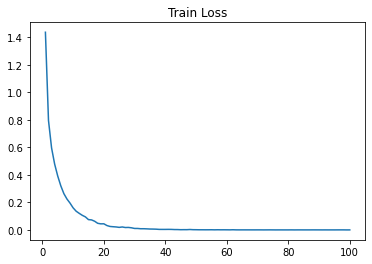

In [ ]:
plt.plot(list(range(1,len(train_loss_)+1)), train_loss_)
plt.title('Train Loss')
plt.show()

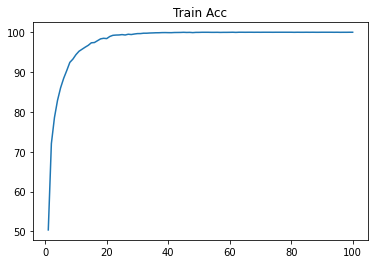

In [ ]:
plt.plot(list(range(1,len(train_acc_)+1)), train_acc_)
plt.title('Train Acc')
plt.show()

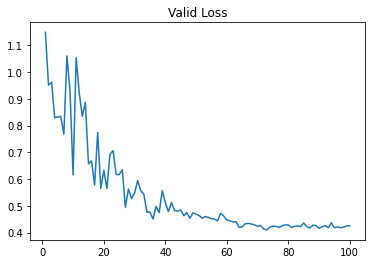

In [ ]:
plt.plot(list(range(1,len(valid_loss_)+1)), valid_loss_)
plt.title('Valid Loss')
plt.show()

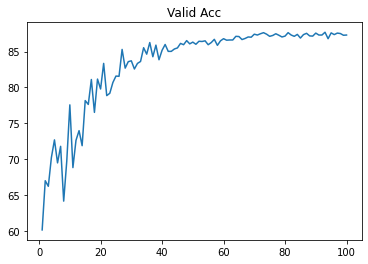

In [ ]:
plt.plot(list(range(1,len(valid_acc_)+1)), valid_acc_)
plt.title('Valid Acc')
plt.show()

In [ ]:
## Inference code

In [ ]:
transform_inference = transforms.Compose([
    transforms.Resize(100),
    transforms.ToTensor(),
])

In [ ]:
cpu = torch.load('rafdb_resnet18.pth', map_location=torch.device('cpu'))

In [ ]:
trainset.labels[87]

array(['train_00453_aligned.jpg', '4'], dtype='<U23')

In [ ]:
img = pil_loader('rafdb/aligned/'+'train_00453_aligned.jpg')
img = transform_test(img)

In [ ]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 100, 100])

In [ ]:
img = img
cpu.eval()
with torch.no_grad():
    output = cpu(img)
print(output)
print(output.argmax())
print(f'prdicted label = {output.argmax()+1}')

tensor([[-4.4285e+00,  2.0176e-03, -1.9586e+00,  7.9597e+00, -1.1678e+00,
          2.9121e+00, -2.0928e+00]])
tensor(3)
prdicted label = 4


In [ ]:
im = torch.randn(1,3,90,90)

In [ ]:
%timeit cpu(im)

31.7 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
